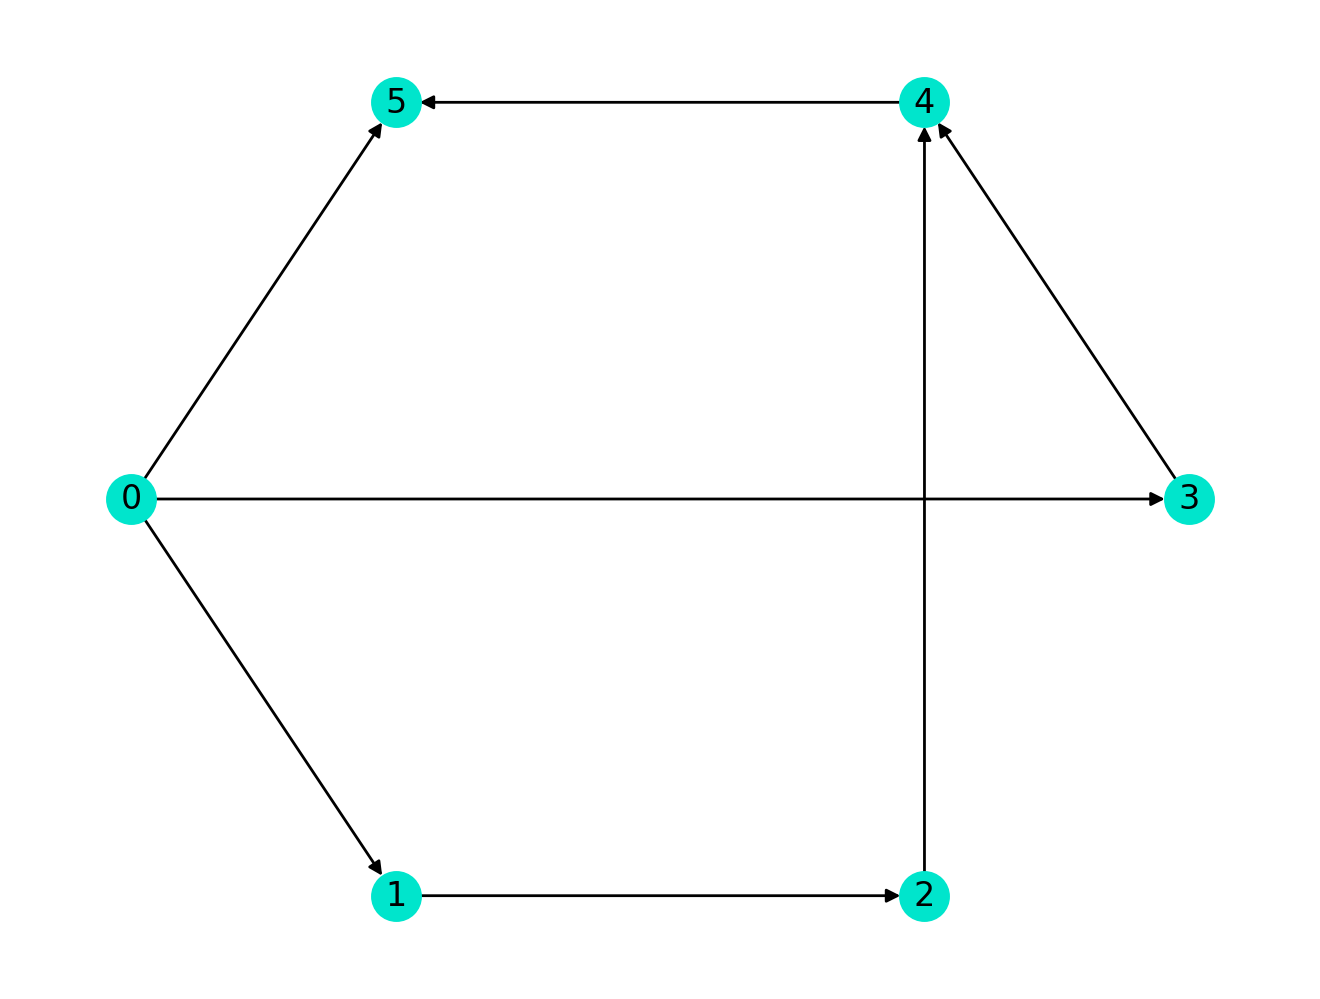

In [58]:
# Firstly, let's visualise our graph

import rustworkx as rx
from rustworkx.visualization import mpl_draw

num_nodes = 6
# The edge syntax is (start, end, weight)
edges = [(0, 1, None), (1, 2, None), (0, 3, None), (3, 4, None), (4, 5, None), (2, 4, None), (0, 5, None)]

# Make a directed acyclic graph
G = rx.PyDAG()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)
layout = rx.digraph_shell_layout(G)
mpl_draw(G, layout, with_labels=True, node_color="#00e5cc")

In [49]:
# Taken from https://qiskit.org/ecosystem/ibm-runtime/tutorials/qaoa_with_primitives.html

# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session

# SciPy minimizer routine
from scipy.optimize import minimize

%config InlineBackend.figure_format='retina'

In [50]:
service = QiskitRuntimeService()
backend = service.get_backend("ibmq_qasm_simulator")

In [63]:
import numpy as np
from qiskit.quantum_info import Pauli, SparsePauliOp

# Define hypothetical data and values for your problem
# Replace these with your actual data when available
num_routes = 3
congestion_costs = [1.0, 2.0, 3.0]  # Cost per kilometer per car for each route
distances = [1, 2, 3]  # Distances of each route in kilometers
num_cars = 50

def get_operator(congestion_costs, distances, num_cars) -> tuple[SparsePauliOp, float]:
    num_routes = len(congestion_costs)
    pauli_list = []
    coeffs = []
    shift = 0

    # Calculate the linear terms corresponding to congestion costs
    for i in range(num_routes):
        for j in range(num_cars):
            x_p = np.zeros(num_routes, dtype=bool)
            z_p = np.zeros(num_routes, dtype=bool)
            z_p[i] = True
            pauli_list.append(Pauli((z_p, x_p)))
            coeffs.append(-0.5 * congestion_costs[i] * distances[i])
            shift += 0.5 * congestion_costs[i] * distances[i]

    # Calculate the quadratic terms for the capacity constraint
    for i in range(num_routes):
        for j in range(i + 1, num_routes):
            x_p = np.zeros(num_routes, dtype=bool)
            z_p = np.zeros(num_routes, dtype=bool)
            z_p[i] = True
            z_p[j] = True
            pauli_list.append(Pauli((z_p, x_p)))
            coeffs.append(1.0)

    return SparsePauliOp(pauli_list, coeffs=coeffs), shift

# Example usage with hypothetical data and values

# Cost per kilometer per car for each route -> Thinnest route, route 1 will have a higher cost
congestion_costs = [3.0, 2.0, 1.0]  
distances = [1, 2, 3]  # Distances of each route in kilometers
num_cars = 50

qubit_op, constant_shift = get_operator(congestion_costs, distances, num_cars)

# qubit_op now represents the Ising Hamiltonian, and offset is a constant shift
print("Ising Hamiltonian:")
print(qubit_op)
print("Constant shift:")
print(constant_shift)


Ising Hamiltonian:
SparsePauliOp(['IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'IZI', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 'ZII', 

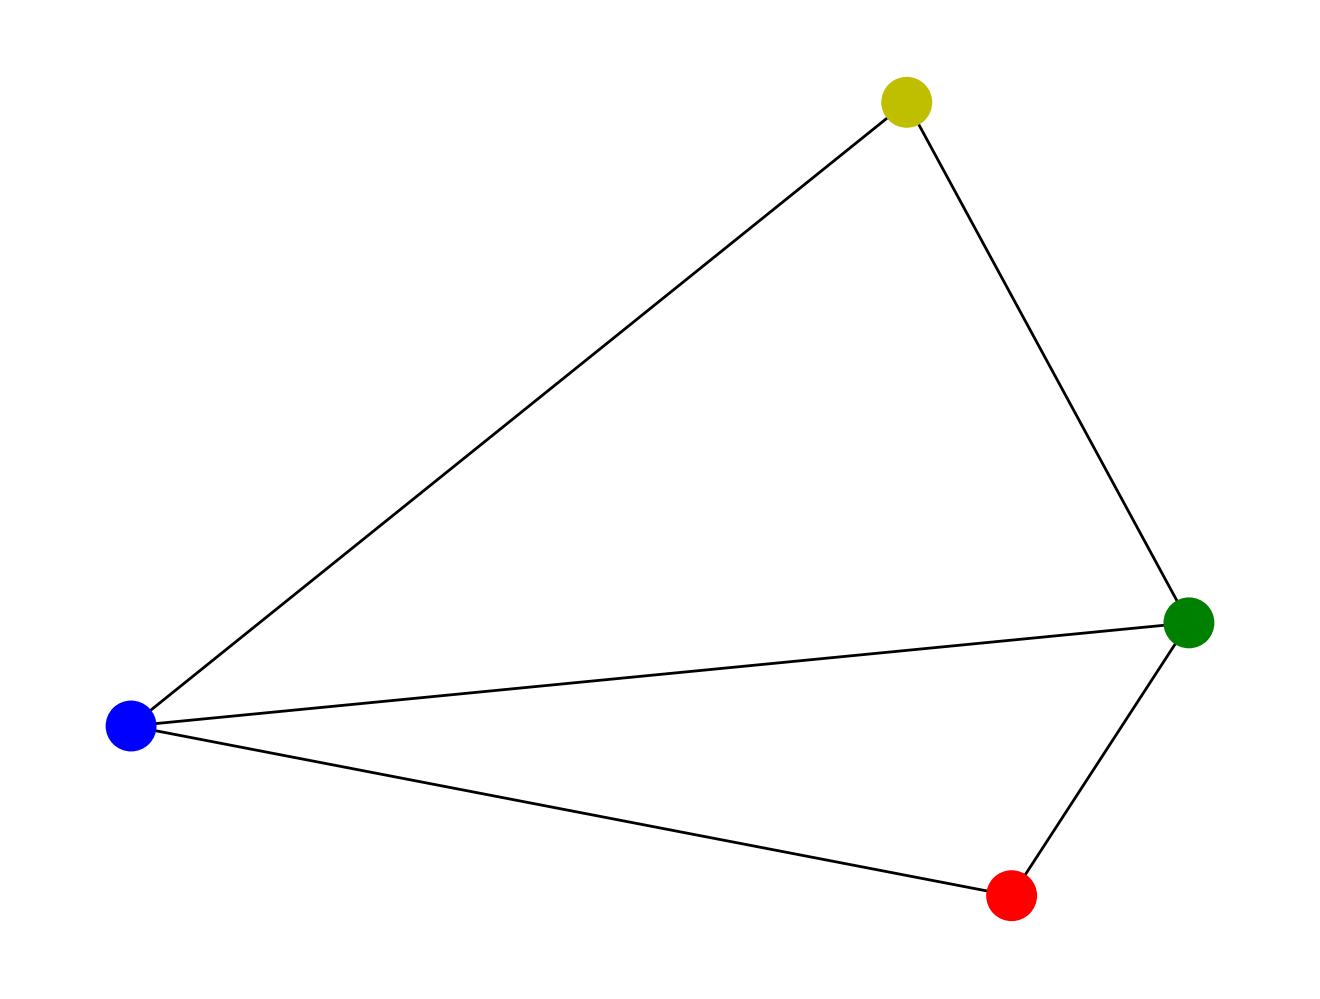

In [59]:
import numpy as np

num_nodes = 4
w = np.array(
    [
        [0.0, 1.0, 1.0, 0.0],
        [1.0, 0.0, 1.0, 1.0],
        [1.0, 1.0, 0.0, 1.0],
        [0.0, 1.0, 1.0, 0.0],
    ]
)

import rustworkx
from rustworkx.visualization import mpl_draw

graph = rustworkx.PyGraph.from_adjacency_matrix(w)
layout = rustworkx.random_layout(graph, seed=50)
colors = ["r", "g", "b", "y"]
mpl_draw(graph, layout, node_color=colors)

In [60]:
from qiskit.quantum_info import Pauli, SparsePauliOp


def get_operator(weight_matrix: np.ndarray) -> tuple[SparsePauliOp, float]:
    r"""Generate Hamiltonian for the graph partitioning
    Notes:
        Goals:
            1: Separate the vertices into two sets of the same size.
            2: Make sure the number of edges between the two sets is minimized.
        Hamiltonian:
            H = H_A + H_B
            H_A = sum\_{(i,j)\in E}{(1-ZiZj)/2}
            H_B = (sum_{i}{Zi})^2 = sum_{i}{Zi^2}+sum_{i!=j}{ZiZj}
            H_A is for achieving goal 2 and H_B is for achieving goal 1.
    Args:
        weight_matrix: Adjacency matrix.
    Returns:
        Operator for the Hamiltonian
        A constant shift for the obj function.
    """
    num_nodes = len(weight_matrix)
    pauli_list = []
    coeffs = []
    shift = 0

    for i in range(num_nodes):
        for j in range(i):
            if weight_matrix[i, j] != 0:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(-0.5)
                shift += 0.5

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(1.0)
            else:
                shift += 1

    return SparsePauliOp(pauli_list, coeffs=coeffs), shift


qubit_op, offset = get_operator(w)

print(qubit_op)

SparsePauliOp(['IIZZ', 'IZIZ', 'IZZI', 'ZIZI', 'ZZII', 'IIZZ', 'IZIZ', 'ZIIZ', 'IIZZ', 'IZZI', 'ZIZI', 'IZIZ', 'IZZI', 'ZZII', 'ZIIZ', 'ZIZI', 'ZZII'],
              coeffs=[-0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,  1. +0.j,  1. +0.j,
  1. +0.j,  1. +0.j,  1. +0.j,  1. +0.j,  1. +0.j,  1. +0.j,  1. +0.j,
  1. +0.j,  1. +0.j,  1. +0.j])
